In [71]:
import os
import shutil
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import display_html
from matplotlib.patches import PathPatch

# Indicates whether the notebook is running on Kaggle or not.
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(exist_ok=True)  # If directory exists, do nothing.

FONT_COLOR = "#141B4D"
BACKGROUND_COLOR = "#F6F5F5"
DF_CMAP = sns.light_palette("#2a357d", as_cmap=True)

MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "xtick.labelsize": 10,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 10,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 10,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.set_theme(rc=MY_RC)


def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


def adjust_box_widths(g, factor, orient="v"):
    """
    Adjust the widths/heights of a seaborn-generated boxplot.
    """
    if orient not in ("v", "h"):
        raise ValueError("The `orient` should be 'v' or 'h'.")

    i = 1
    if orient == "h":
        i = 0

    # iterating through Axes instances
    for ax in g.axes:
        # iterating through axes artists:
        for c in ax.get_children():
            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current height/width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                min_ = np.min(verts_sub[:, i])
                max_ = np.max(verts_sub[:, i])
                mid_ = 0.5 * (min_ + max_)
                half_ = 0.5 * (max_ - min_)

                # setting new height of box
                min_new_ = mid_ - factor * half_
                max_new_ = mid_ + factor * half_
                verts_sub[verts_sub[:, i] == min_, i] = min_new_
                verts_sub[verts_sub[:, i] == max_, i] = max_new_

                # setting new height/width of median line
                if orient == "v":
                    for l in ax.lines:
                        if len(l.get_ydata()) == 2 and np.all(
                            l.get_ydata() == [min_, max_]
                        ):
                            l.set_ydata([min_new_, max_new_])
                elif orient == "h":
                    for l in ax.lines:
                        if len(l.get_xdata()) == 2 and np.all(
                            l.get_xdata() == [min_, max_]
                        ):
                            l.set_xdata([min_new_, max_new_])


def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
    correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
        print("Monkey-patching SimpleImputer.get_feature_names_out()")
        SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values())
            + [Parameter("feature_names_out", Parameter.KEYWORD_ONLY)]
        )

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out


monkey_patch_get_signature_names_out()


In [2]:
competition = "titanic"

if not ON_KAGGLE:
    download_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, index_col="PassengerId")
test = pd.read_csv(test_path, index_col="PassengerId")


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


class NewFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")

        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns, dtype=object)

        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features.")
        check_is_fitted(self)

        Xc = X.copy()
        Xc["IsAlone"] = Xc.eval("SibSp + Parch == 0").astype(int)

        Xc["Title"] = Xc["Name"].str.extract(r" ([A-Za-z]+)\.")
        common_titles = ["Mr", "Miss", "Mrs", "Master"]
        unique_titles = np.setdiff1d(Xc["Title"], common_titles).tolist()
        Xc["Title"] = Xc["Title"].replace(unique_titles, "Other")

        Xc["CabinDeck"] = Xc["Cabin"].str[0]

        return Xc

    def get_feature_names_out(self, input_features=None):
        return np.r_[self.feature_names_in_, ["IsAlone", "Title", "CabinDeck"]]


In [4]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer


preprocess = make_pipeline(
    NewFeatureAdder(),
    make_column_transformer(
        (
            StandardScaler(),
            ["Age"],
        ),
        (
            make_pipeline(
                SimpleImputer(strategy="median"),
                FunctionTransformer(
                    func=np.log1p, inverse_func=np.expm1, feature_names_out="one-to-one"
                ),
                StandardScaler(),
            ),
            ["Fare"],
        ),
        (
            make_pipeline(
                SimpleImputer(strategy="most_frequent"),
                OneHotEncoder(handle_unknown="ignore"),
            ),
            ["Pclass", "Sex", "Embarked", "IsAlone", "Title"],
        ),
        verbose_feature_names_out=False,
    ),
    # At this stage, only the `Age` attribute needs imputation.
    KNNImputer(n_neighbors=5),
)


In [18]:
from sklearn.model_selection import train_test_split

y = train["Survived"]
X = train.drop("Survived", axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = preprocess.fit_transform(X_train)
X_valid = preprocess.transform(X_valid)

assert np.all(np.isfinite(X_train)) == True
assert np.all(np.isfinite(X_valid)) == True

assert np.any(np.isnan(X_train)) == False
assert np.any(np.isnan(X_valid)) == False

transformed_features = preprocess.get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=transformed_features)
X_train.head()


,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,IsAlone_0,IsAlone_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0.110023,1.124592,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.469322,-3.014278,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.174102,2.508198,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.815864,-0.627019,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.082384,0.361872,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


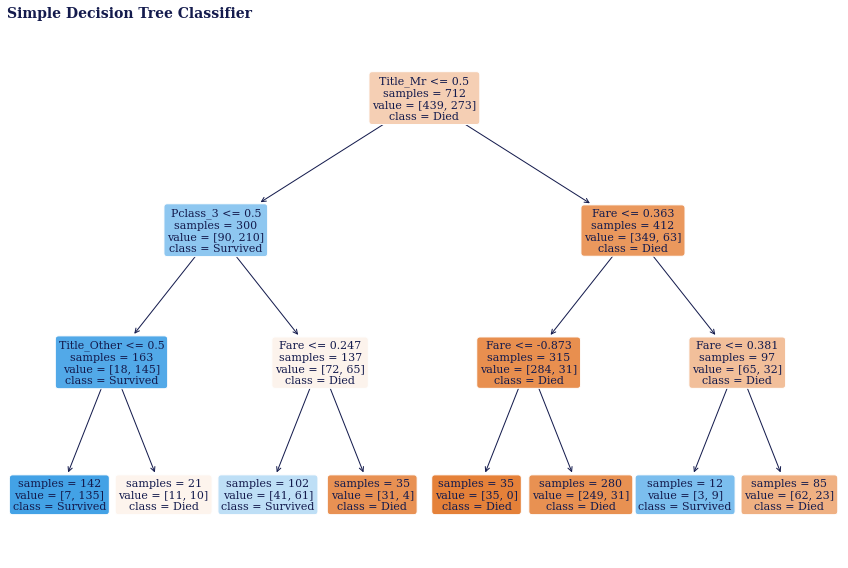

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
plot_tree(
    decision_tree=tree_clf,
    feature_names=transformed_features,
    class_names=["Died", "Survived"],
    filled=True,
    impurity=False,
    rounded=True,
    ax=ax,
    fontsize=11,
)
plt.title("Simple Decision Tree Classifier", loc="left")
plt.show()


In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif


lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_info = np.abs(lda.scalings_.ravel())
lda_info = lda_info / lda_info.sum()

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)
forest_info = forest.feature_importances_

mutual_info = mutual_info_classif(X_train, y_train, random_state=42)
mutual_info = mutual_info / np.sum(mutual_info)

importances = pd.DataFrame(
    [lda_info, forest_info, mutual_info],
    columns=transformed_features,
    index=["LDA", "Random Forest", "Mutual Information"],
).T

importances = importances.loc[
    importances.mean(axis=1).sort_values(ascending=False).index
]

importances.style.background_gradient(DF_CMAP)


,LDA,Random Forest,Mutual Information
Fare,0.010110,0.251069,0.141294
Sex_male,0.157053,0.096177,0.129389
Sex_female,0.157053,0.087023,0.136282
Age,0.036387,0.247585,0.055411
Title_Mr,0.006145,0.090206,0.150543
Title_Master,0.194155,0.009764,0.024734
Pclass_3,0.089684,0.054325,0.063624
Pclass_1,0.108221,0.030821,0.039572
Title_Miss,0.061964,0.023379,0.058005
Title_Mrs,0.014124,0.026007,0.072490


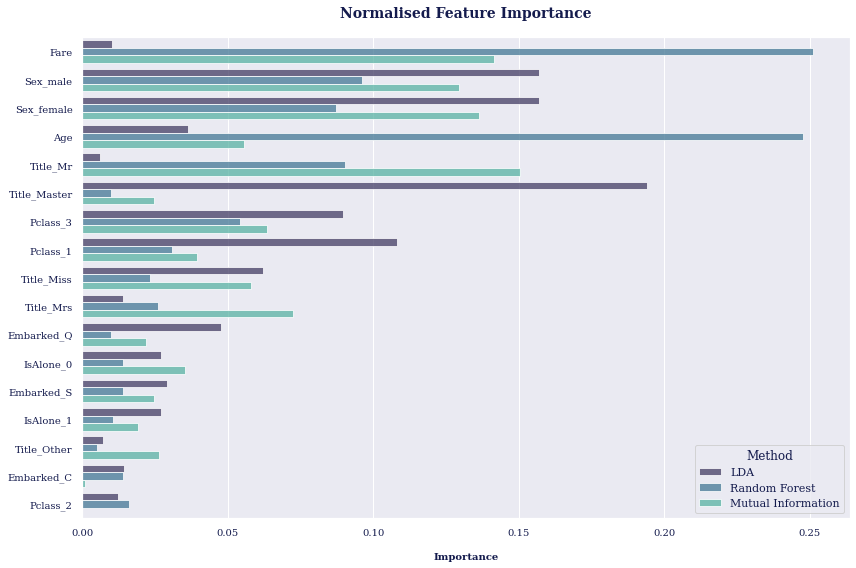

In [34]:
melted = importances.melt(
    var_name="Method", value_name="Importance", ignore_index=False
)

plt.figure(figsize=(12, 8), tight_layout=True)
ax = sns.barplot(
    data=melted,
    x="Importance",
    y=melted.index,
    hue="Method",
    palette="mako",
    alpha=0.75,
)
plt.title("Normalised Feature Importance", pad=20)
plt.show()


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
baseline_scores = {}
classifiers = (
    LogisticRegression(random_state=42),
    RidgeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    LinearSVC(random_state=42),
    NuSVC(random_state=42),
    SVC(random_state=42),
    KNeighborsClassifier(),
)

for classifier in classifiers:
    name = classifier.__class__.__name__
    clf_pipeline = make_pipeline(preprocess, classifier)
    baseline_scores[name] = cross_val_score(
        clf_pipeline, X, y, cv=skf, scoring="accuracy"
    )
    print("Training:".ljust(15), name)


Training:            LogisticRegression
Training:            RidgeClassifier
Training:            RandomForestClassifier
Training:            ExtraTreesClassifier
Training:            GradientBoostingClassifier
Training:            LinearSVC
Training:            NuSVC
Training:            SVC
Training:            KNeighborsClassifier


In [36]:
baseline_scores = pd.DataFrame(baseline_scores)
baseline_scores = baseline_scores[baseline_scores.median().sort_values().index]
baseline_scores


,RidgeClassifier,ExtraTreesClassifier,LinearSVC,KNeighborsClassifier,NuSVC,SVC,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier
0,0.811111,0.788889,0.811111,0.800000,0.844444,0.877778,0.833333,0.822222,0.866667
1,0.775281,0.775281,0.786517,0.831461,0.752809,0.786517,0.797753,0.797753,0.831461
2,0.786517,0.808989,0.797753,0.797753,0.786517,0.797753,0.797753,0.797753,0.853933
3,0.764045,0.797753,0.775281,0.797753,0.786517,0.797753,0.820225,0.820225,0.842697
4,0.797753,0.786517,0.797753,0.797753,0.786517,0.808989,0.786517,0.820225,0.831461
5,0.831461,0.775281,0.831461,0.764045,0.808989,0.808989,0.842697,0.797753,0.820225
6,0.764045,0.820225,0.752809,0.865169,0.808989,0.853933,0.764045,0.853933,0.808989
7,0.786517,0.764045,0.786517,0.820225,0.820225,0.820225,0.831461,0.775281,0.797753
8,0.842697,0.808989,0.842697,0.831461,0.865169,0.865169,0.865169,0.820225,0.831461
9,0.842697,0.797753,0.831461,0.797753,0.831461,0.797753,0.808989,0.820225,0.820225


In [43]:
baseline_desc = (
    baseline_scores.describe().T.drop("count", axis=1).rename(columns=str.title)[::-1]
)
baseline_desc.style.background_gradient(DF_CMAP)


,Mean,Std,Min,25%,50%,75%,Max
GradientBoostingClassifier,0.830487,0.020426,0.797753,0.820225,0.831461,0.839888,0.866667
RandomForestClassifier,0.812559,0.021311,0.775281,0.797753,0.820225,0.820225,0.853933
LogisticRegression,0.814794,0.029733,0.764045,0.797753,0.814607,0.832865,0.865169
SVC,0.821486,0.032243,0.786517,0.797753,0.808989,0.845506,0.877778
NuSVC,0.809164,0.032855,0.752809,0.786517,0.808989,0.828652,0.865169
KNeighborsClassifier,0.810337,0.027648,0.764045,0.797753,0.798876,0.828652,0.865169
LinearSVC,0.801336,0.028126,0.752809,0.786517,0.797753,0.826373,0.842697
ExtraTreesClassifier,0.792372,0.017698,0.764045,0.778090,0.793321,0.806180,0.820225
RidgeClassifier,0.800212,0.030412,0.764045,0.778090,0.792135,0.826373,0.842697


In [57]:
fig = px.box(
    baseline_scores,
    points="all",
    height=500,
    width=750,
    range_y=(0.72, 0.90),
    color="variable",
    color_discrete_sequence=px.colors.diverging.delta,
    labels={"variable": "Classifier", "value": "Accuracy"},
    title="Baseline Accuracy within Stratified 10-Fold CV",
)
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.update_xaxes(tickangle=45)
fig.update_traces(marker={"size": 4})
fig.show()


In [61]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score


rf = make_pipeline(preprocess, RandomForestClassifier(random_state=42))
lr = make_pipeline(preprocess, LogisticRegression(random_state=42))
gb = make_pipeline(preprocess, GradientBoostingClassifier(random_state=42))

rf_scores, lr_scores, gb_scores = {}, {}, {}

for scores, classifier in zip((rf_scores, lr_scores, gb_scores), (rf, lr, gb)):
    name = classifier[-1].__class__.__name__

    probabilities = cross_val_predict(classifier, X, y, cv=skf, method="predict_proba")
    positive_class_proba = probabilities[:, 1]
    predictions = np.argmax(probabilities, axis=1)

    scores["Classifier"] = name
    scores["Accuracy"] = accuracy_score(y, predictions)
    scores["Precision"] = precision_score(y, predictions)
    scores["Recall"] = recall_score(y, predictions)
    scores["F1"] = f1_score(y, predictions)
    scores["ConfusionMatrix"] = confusion_matrix(y, predictions)
    scores["AUC-ROC"] = roc_auc_score(y, positive_class_proba)
    scores["FPR-TPR-Threshold"] = roc_curve(y, positive_class_proba)


In [81]:
metrics = pd.DataFrame(
    {
        rf_scores["Classifier"]: [
            rf_scores["Accuracy"],
            rf_scores["Precision"],
            rf_scores["Recall"],
            rf_scores["F1"],
            rf_scores["AUC-ROC"],
        ],
        lr_scores["Classifier"]: [
            lr_scores["Accuracy"],
            lr_scores["Precision"],
            lr_scores["Recall"],
            lr_scores["F1"],
            lr_scores["AUC-ROC"],
        ],
        gb_scores["Classifier"]: [
            gb_scores["Accuracy"],
            gb_scores["Precision"],
            gb_scores["Recall"],
            gb_scores["F1"],
            gb_scores["AUC-ROC"],
        ],
    },
    index=["Accuracy", "Precision", "Recall", "F1", "AUC-ROC"],
)

metrics.T.style.background_gradient(DF_CMAP)


,Accuracy,Precision,Recall,F1,AUC-ROC
RandomForestClassifier,0.812570,0.772586,0.725146,0.748115,0.867417
LogisticRegression,0.814815,0.770642,0.736842,0.753363,0.861005
GradientBoostingClassifier,0.830527,0.823729,0.710526,0.762951,0.872764


In [105]:
fig = px.line(
    metrics,
    markers=True,
    height=500,
    width=750,
    range_y=(0.65, 0.90),
    labels={"variable": "Classifier", "value": "Value", "index": "Metric"},
    title="Top-3 Most Promising Models - Metrics Summary",
    color="variable",
    line_dash="variable",
    symbol="variable",
    color_discrete_sequence=["#0f173b", "#c73c1a", "#454d82"],
    line_dash_sequence=["solid", "dash", "dot"],
)
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


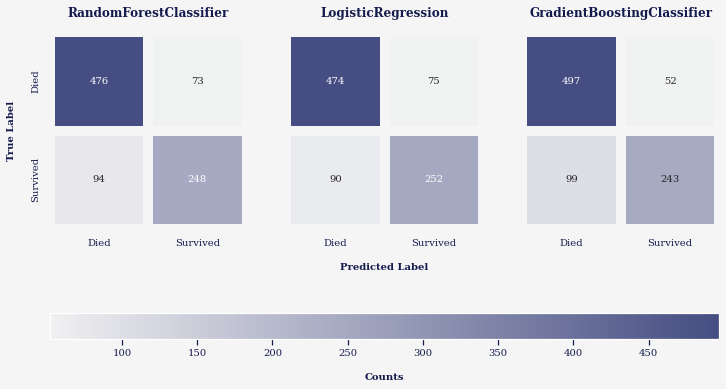

In [74]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(12, 6))
gs = GridSpec(nrows=2, ncols=3, figure=fig, height_ratios=(0.9, 0.1))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, :])
plt.subplots_adjust(hspace=0.5)

axes = (ax1, ax2, ax3)
titles = (
    rf_scores["Classifier"],
    lr_scores["Classifier"],
    gb_scores["Classifier"],
)
confusion_matrices = (
    rf_scores["ConfusionMatrix"],
    lr_scores["ConfusionMatrix"],
    gb_scores["ConfusionMatrix"],
)

for ax, confusion_matrix, title in zip(axes, confusion_matrices, titles):
    plt.sca(ax)
    plt.title(title, fontsize=12)
    sns.heatmap(
        confusion_matrix,
        square=True,
        linewidths=10,
        linecolor=BACKGROUND_COLOR,
        annot=True,
        cmap=sns.light_palette("#454d82", as_cmap=True),
        fmt=".0f",
        cbar=False,
    )
    plt.gca().set_xticklabels(["Died", "Survived"])
    plt.gca().set_yticklabels(["Died", "Survived"])
    if not ax == ax1:
        plt.gca().set_yticklabels([])

plt.sca(ax1)
plt.ylabel("True Label")
plt.sca(ax2)
plt.xlabel("Predicted Label")

ax4.grid(False)
fig.colorbar(ax3.get_children()[0], cax=ax4, orientation="horizontal", label="Counts")

plt.show()


In [127]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=rf_scores["FPR-TPR-Threshold"][0],
        y=rf_scores["FPR-TPR-Threshold"][1],
        name=rf_scores["Classifier"],
        line=dict(dash="solid", color="#0f173b"),
    )
)
fig.add_trace(
    go.Scatter(
        x=lr_scores["FPR-TPR-Threshold"][0],
        y=lr_scores["FPR-TPR-Threshold"][1],
        name=lr_scores["Classifier"],
        line=dict(dash="dash", color="#c73c1a"),
    )
)
fig.add_trace(
    go.Scatter(
        x=gb_scores["FPR-TPR-Threshold"][0],
        y=gb_scores["FPR-TPR-Threshold"][1],
        name=gb_scores["Classifier"],
        line=dict(dash="dot", color="#454d82"),
    )
)
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        name="Dummy Classifier",
        line=dict(dash="longdash", color="black"),
    )
)

fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
        range=(0, 1),
        title="False Positive Rate (Fall-Out)",
    ),
    yaxis=dict(
        scaleanchor="x",
        scaleratio=1,
        range=(0, 1),
        title="True Positive Rate (Recall)",
    ),
    legend=dict(title="Classifier"),
    title="Top-3 Most Promising Classifiers - ROC",
    height=500,
    width=750,
)
fig.show()
